System identification of a heat pump model with design of the cooling cuircuit to fit the data sheet of a Lambda EU15L heat pump.\
https://lambda-wp.at/wp-content/uploads/2024/10/20241017_Technisches-Datenblatt_HF_v1.pdf

In [117]:
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
import CoolProp.CoolProp as CP

In [118]:
# definition of the heat pump model
def c_hp_fun(eta1, Tsource, Tsink):

    #P_el = 2000    # W
    P_el = 5700    # W
    fluid = 'R290' # coolant
    x1=1           # state of coolant at point 1 (after evaporation before compression), steam content is 1
    T1=Tsource     # °C
    x3=0           # state of coolant at point 3 (after condensation before expansion), steam content is 0
    T3=Tsink       # °C

    # State 1:
    h1=CP.PropsSI('H','T',T1+273.15,'Q',x1,fluid)
    p1=CP.PropsSI('P','T',T1+273.15,'Q',x1,fluid)
    s1=CP.PropsSI('S','T',T1+273.15,'Q',x1,fluid)

    # State 3:
    h3=CP.PropsSI('H','T',T3+273.15,'Q',x3,fluid)
    p3=CP.PropsSI('P','T',T3+273.15,'Q',x3,fluid)
    s3=CP.PropsSI('S','T',T3+273.15,'Q',x3,fluid)

    # State 2:
    p2=p3 
    h2s=CP.PropsSI('H','P',p2,'S',s1,fluid)
    h2=h1+(h2s-h1)/eta1
    T2=CP.PropsSI('T','P',p2,'H',h2,fluid)
    s2=CP.PropsSI('S','P',p2,'H',h2,fluid)

    # State 4: 
    p4=p1 # (4 -> 1: heat exchange with constant pressure)
    h4=h3 # (3 -> 4: expansion with constant enthalpy)
    T4=CP.PropsSI('T','P',p4,'H',h4,fluid)
    s4=CP.PropsSI('S','P',p4,'H',h4,fluid)


    m1 = P_el / (h2-h1)

    dot_Q_hp = m1 * (h2-h3)

    cop = dot_Q_hp / P_el
    return cop

In [119]:
# definition of refernce cop with changing ambient temperature, data from datasheet for a middle heating mode, low and high temperature application
def d_hp_fun(T_source, T_sink):
    cop = {35: {-10:3.16, -7:3.59, 2:5.70, 7:7.24, 12:8.35},
           55: {-10:2.39, -7:2.76, 2:4.37, 7:5.70, 12:7.50}
    }
    return cop[T_sink][T_source]

In [120]:
# error calculation
# error is defined as the quadratic differnce between the calculated cop from the heat pump model and the cop from the 
# datasheet at the defined source and sink temperatures
def residuals(eta, Tsource_list, Tsink_list):
    res_list = []
    for Tsink in Tsink_list:
        for Tsource in Tsource_list:
            res = c_hp_fun(eta, Tsource, Tsink) - d_hp_fun(Tsource, Tsink)
            res_list.append(res)
    return sum(np.array([res_list]).flatten()**2)

In [121]:
# optimize eta (isentropic efficiency) of the compressor with a leatsquare of the error
tsources = [-10, -7, 2, 7, 12]
tsinks = [35, 55]
popt, pcov = optimize.leastsq(residuals, [0.5], args=(tsources, tsinks))
print(f'eta = {popt[0]:.4f}')

eta = 0.7414


In [122]:
popt_b = optimize.brute(residuals, ((0.4, 0.8),), args=(tsources, tsinks))
print(f'eta = {popt_b[0]:.4f}')

eta = 0.7414


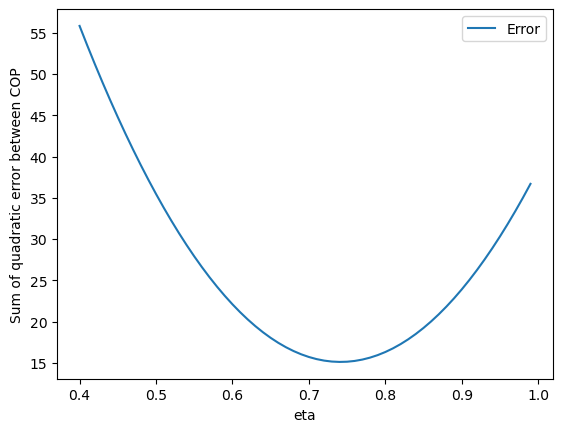

In [123]:
# plot of the error with a variation of eta between 0.4 and 1. The curve shows the lowest values at the optimized eta value.
etalist = np.arange(0.4, 1, 0.01)
plt.figure()
plt.plot(etalist, [residuals(e, tsources, tsinks) for e in etalist], label='Error')
plt.legend()
plt.ylabel('Sum of quadratic error between COP')
plt.xlabel('eta')
plt.show()

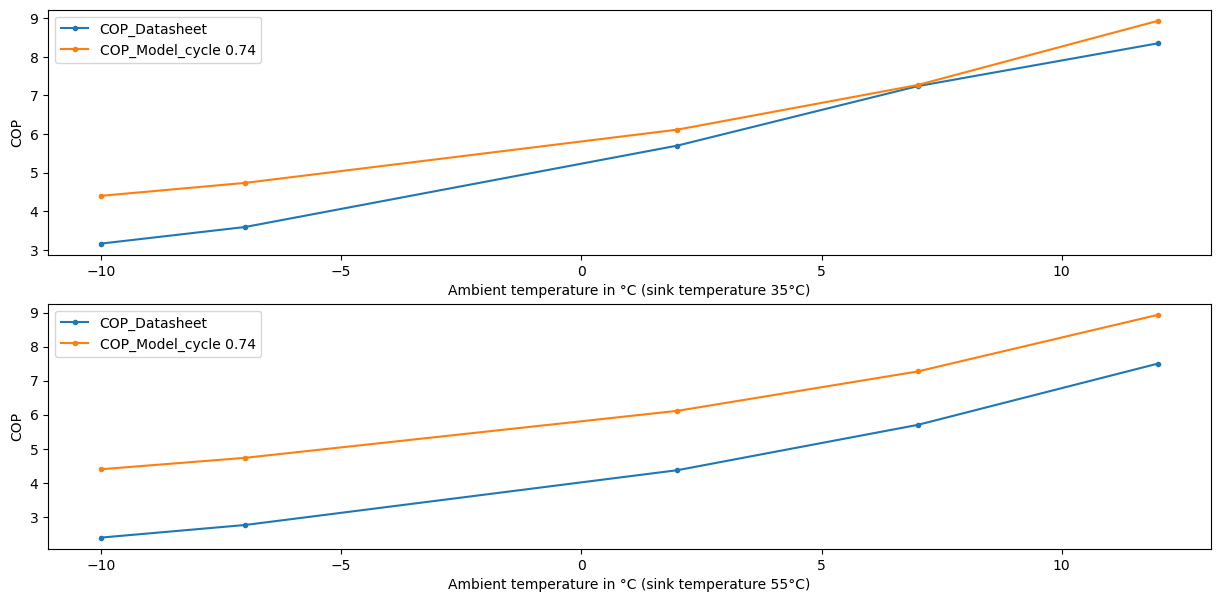

In [124]:
fig, axs = plt.subplots(2, 1, figsize=(15, 7), squeeze=False)
eta = popt[0]
axs[0, 0].plot(tsources, [d_hp_fun(t, 35) for t in tsources], label='COP_Datasheet', marker='.')
axs[0, 0].plot(tsources, [c_hp_fun(eta,t, 35) for t in tsources], label=f'COP_Model_cycle {eta:.2f}', marker='.')
axs[0, 0].legend()
axs[0, 0].set_ylabel('COP')
axs[0, 0].set_xlabel('Ambient temperature in °C (sink temperature 35°C)')

axs[1, 0].plot(tsources, [d_hp_fun(t, 55) for t in tsources], label='COP_Datasheet', marker='.')
axs[1, 0].plot(tsources, [c_hp_fun(eta, t, 35) for t in tsources], label=f'COP_Model_cycle {eta:.2f}', marker='.')
axs[1, 0].legend()
axs[1, 0].set_ylabel('COP')
axs[1, 0].set_xlabel('Ambient temperature in °C (sink temperature 55°C)')    

plt.show()